# Challenge based Learning:

## TASK
Count the number of trees in Campus Golm. Estimate the area that is covered by trees on campus. How many trees (in %) are deciduous?

## Members
- Emmanuel Olguin	
- Raphael Kluge 		
- Nikolas Bertrand	

For this challenge based project we decided to use mainly Python and R programming. 

After fighting with different tools, applications and R we came to the results below. 

While they are not perfect, considering time constraints they give a general picture of the results. Now it all depends on fine tuning. 

To complete the challenge one can follow the general outline:

1. Read the .las file: Start by reading the .las file, which is a common file format used for storing LiDAR data, and load it into memory.
2. Preprocess the data: Once the .las file is loaded, you may need to preprocess the data to remove noise, filter out points that are not relevant to trees, or perform any necessary transformations. This step is important to ensure accurate tree identification.
3. Segment the point cloud: Next, you need to segment the point cloud into individual trees. In general, this can be done by applying clustering algorithms such as DBSCAN (Density-Based Spatial Clustering of Applications with Noise) or region growing algorithms. These algorithms group nearby points together based on their spatial proximity or other attributes.
4. Extract tree features: After segmenting the point cloud into individual trees, you can extract various features from each tree, such as height, crown diameter, or density. These features can be calculated using geometric or statistical methods.
5. Classify the trees: Once the features are extracted, you can classify the trees into different species or categories. This can be done using machine learning algorithms, such as random forests or support vector machines, trained on labeled tree data. 
6. Visualize the results: Finally, you can visualize the identified trees and their attributes to gain insights or generate reports. You can use libraries like matplotlib in Python or lidRVis in R to create visualizations of the identified trees.

In [2]:
# Import libraries
import laspy
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.spatial import cKDTree
from scipy import stats

# Import R libraries 
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
#load_ext rpy2.ipython # first time only
%load_ext rpy2.ipython


In [ ]:
%%R
# LOAD R LIBRARIES
library(lidR)
library(raster)
library(ForestTools)
library(sf)
library(rgdal)


# STEP 1 Filter the input data. 

For the first to tasks we mainly use a lidar file in form of .las as input data.
The las file has 6 return and some classification included. 

In [7]:
#Load Data 
las = laspy.read("/home/nibe/PROJECTS/golm_tree_analysis/data/Golm_May06_2018_Milan_UTM33N_WGS84_6digit_cl.las")

print(f"{np.unique(las.classification)} are the unique classificationsin the point cloud")
print(np.unique(las.return_num))
# Get information about the point spacing
point_spacing = las.header.scale[0]  # Assuming the scale is the same in all dimensions
# Calculate the resolution
resolution = 1 / point_spacing  # Assuming the point spacing is in meters
# Print the resolution
print(f"Resolution: {resolution} points per meter")

[1 2 5 6 7] are the unique classificationsin the point cloud
[1 2 3 4 5 6]
Resolution: 100.0 points per meter


According to the ASPRS standard, high vegetation is represented by the classification value 5. But since that includes unfortunately some building parts as well we need to further experiement with classification and return values

To further filter these points based on the return number, you can do so by adding another condition to your filter. 

In [188]:

filtered_points53 = las.points[(las.classification == 5) & (las.return_num == 3)]
print(f"returns {len(filtered_points)} points")

las53 = laspy.LasData(las.header)
las53.points = filtered_points53.copy()

new_file = laspy.create(point_format=las.header.point_format, file_version=las.header.version)
new_file.points = filtered_points53.copy()
new_file.write('data/final_points53.las')

returns 8909526 points


In [257]:
filtered_points51 = las.points[(las.classification == 5) & (las.return_num == 1)]
print(f"returns {len(filtered_points)} points")

las51 = laspy.LasData(las.header)
las51.points = filtered_points51.copy()

new_file = laspy.create(point_format=las.header.point_format, file_version=las.header.version)
new_file.points = filtered_points51.copy()
new_file.write('data/final_points51.las')

returns 8909526 points


In [103]:
# Apply the first filter: classification == 5 and return_num == 1
mask_51 = (las.classification == 5) & (las.return_num == 1)
filtered_points_51 = las.points[mask_51]
print(f"returns {len(filtered_points_51)} points")

# Apply the second filter: classification == 5 and return_num == 1
mask_61 = (las.classification == 6) & (las.return_num == 1)
filtered_points_61 = las.points[mask_61]
print(f"returns {len(filtered_points_61)} points")



returns 1763768 points
returns 2027141 points


As seen below there is still some overlap. 
The problem is normaly it should be enough to just use classification ==5 and return 1..3 but the amount of trees is reduced significantly if for examp class=5 return ==2 as seen in the third image.
Trees for example in front of the mensa are missing. and on some other smaller points. 

Other filteres were not that fruitful either.  even when using classification == 5 and return_num == 3 ,4 the amount of vegetation is removed drasticly. That is why the only possible approach would be to remove the building leftovers by hand. 
The last two images are 5.2 and 5.3 respectively


<img src="img/filtered_data51.png" alt="points 5-1" width="400"/>
<img src="img/filtered_data61.png" alt="points 6-1" width="400"/>
<img src="img/filtered_data_52.png" alt="points 5-2" width="400"/>
<img src="img/data53.png" alt="points 5-2" width="400"/>

# BEST RESULTS where achieved by using : 

In [329]:
filtered_points = las.points[(las.classification == 5) & (las.return_num == 1)]
ew_las = laspy.LasData(las.header)
new_las.points = filtered_points.copy()
new_las.write('data/no_buildings_filtered_data.las')
len(filtered_points)

1763768

# Next: Tree segmentation 

the pre-processing was done using python, next we switch to R and manly use the forest tool

In [5]:
%%R
library(lidR)
#las <- readLAS("/home/nibe/PROJECTS/golm_tree_analysis/data/no_buildings_filtered_data.las", select = "xyzr")
las <- readLAS("/home/nibe/PROJECTS/golm_tree_analysis/data/no_buildings_filtered_data.las", select = "xyzr", filter = "-keep_first -drop_classification 7 6 2 1 4")




The segment_trees function in R is used to segment a point cloud into individual trees. It assigns an ID to each point by inserting a new attribute named treeID in the LAS object. This means that every point is associated with a specific tree. This function is part of the lidR package, which is oriented towards point clouds, and provides an immediate way to access a segmented point cloud.


In [6]:
%%R
las <- segment_trees(las, li2012(dt1 = 1.5, dt2 = 2, R = 2, Zu = 15, hmin = 1, speed_up = 2))

li2012(dt1 = 1.5, dt2 = 2, R = 2, Zu = 15, hmin = 2, speed_up = 2) is the algorithm used for the segmentation. li2012 is an "all-in-one" point cloud based method for tree segmentation. The parameters dt1, dt2, R, Zu, hmin, and speed_up are specific to the li2012 algorithm. 

Once the trees are segmented, you can perform various analyses at the point-cloud level. For example, you can extract every tree to derive measurements, or delineate the crown shapes of each tree using the crown_metrics() function r-lidar.github.io.

Furthermore, Segment Trees are a type of data structure that stores information about a range of elements in its nodes. It allows users to modify the array and perform range queries in smaller complexity. Applications of Segment Trees include interval scheduling, range-based statistics, and image processing

# NEXT: create Canopy height models 
A Canopy Height Model (CHM) in remote sensing represents the height of the trees. It is the distance between the ground and the top of the trees. CHM is calculated by subtracting the Digital Elevation Model (DEM) from the Digital Surface Model (DSM). The DEM represents the elevation of the earth’s surface, excluding trees, buildings, and other objects. The DSM represents the top of the surface, including the actual heights of trees, buildings, and other objects on the earth’s surface. By subtracting the DEM from the DSM, the residual value or difference between the top of the earth surface and the ground is obtained, which should be the heights of the trees.

Fortunately the ForestTools package have this built in, we just need to choose the algorithm and resolution as well as the subcircle

In [8]:
%%R
# Point-to-raster 2 resolutions
#chm_p2r_05 <- rasterize_canopy(las, 0.5, p2r(subcircle = 0.2), pkg = "terra")
chm_p2r_1 <- rasterize_canopy(las, 1, p2r(subcircle = 0.2), pkg = "terra")
#chm_p2r_2 <- rasterize_canopy(las, 2, p2r(subcircle = 0.2), pkg = "terra")
#chm_p2r_3 <- rasterize_canopy(las, 3, p2r(subcircle = 0.2), pkg = "terra")


2R Algorithm: The "P2R" stands for Point-to-Raster. This algorithm is used for converting point cloud data to a raster format.
LiDAR data often comes as a "point cloud," where each point represents a return from the LiDAR sensor. These points all have 3D coordinates associated with them. To generate a raster from this dataset, we have to translate these multiples points in the 3-dimensional space to a 2-dimensional regular grid. That is where the P2R algorithm comes in. It can translate and reorganize this point cloud data into the form of a 2D raster. Which can then be used for further analysis or visualization.

In [9]:
%%R
# Post-processing median filter
kernel <- matrix(1, 3, 3)
#chm_p2r_05_smoothed <- terra::focal(chm_p2r_05, w = kernel, fun = median, na.rm = TRUE)
chm_p2r_1_smoothed <- terra::focal(chm_p2r_1, w = kernel, fun = median, na.rm = TRUE)
#chm_p2r_2_smoothed <- terra::focal(chm_p2r_2, w = kernel, fun = median, na.rm = TRUE)
#chm_p2r_3_smoothed <- terra::focal(chm_p2r_3, w = kernel, fun = median, na.rm = TRUE)

Pitfree Function: The pitfree function is used for the creation of a pit-free canopy height model (CHM). A CHM is a raster where each pixel value represents the height of the tree canopy above the ground.
In a regular CHM model, data voids or pits are common because there are areas where the LiDAR sensor did not retrieve any return. These voids appear as depressions in the CHM and lead to an underestimation of the canopy height.

The pitfree function uses algorithms to solve these issues and generate a CHM that is void of these depressions or pits, hence the term "pit-free".

In [10]:
%%R
chm_pitfree_05_1 <- rasterize_canopy(las, 1, pitfree(), pkg = "terra")
#chm_pitfree_05_2 <- rasterize_canopy(las, 2, pitfree(subcircle = 0.2), pkg = "terra")
#chm_pitfree_05_3 <- rasterize_canopy(las, 3, pitfree(), pkg = "terra")
#chm_pitfree_05_3s <- rasterize_canopy(las, 3, pitfree(subcircle = 0.2), pkg = "terra")

# Next we create a function / multiple function for the window size.
This can be done fixed or dynamicaly based on the height of the points. 

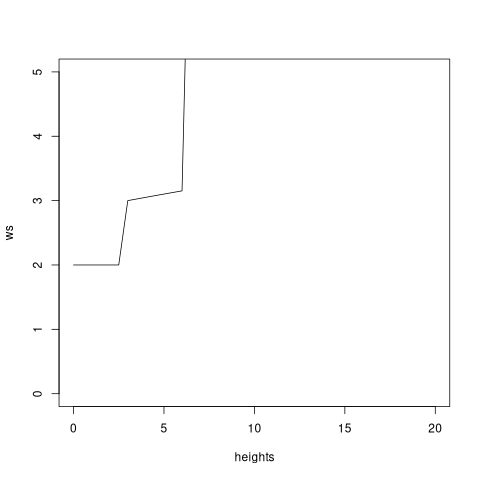

In [11]:
%%R
# A dynamic
f <- function(x) {
  y <- 2.6 * (-(exp(-0.02*(x-3)) - 1)) + 3
  y[x < 3] <- 2
  y[x > 6] <- 9
  return(y)
}

heights <- seq(0,20,0.5)
ws <- f(heights)
plot(heights, ws, type = "l",  ylim = c(0,5))

- The input x is passed to the function.
- Then y is calculated based on the formula 2.6 * (-(exp(-0.02*(x-3)) - 1)) + 3. This is a type of exponential decay function modified by a scalar and offset.

- After the value of y is computed, it is then adjusted. If x is less than 3, y is set to 2 and if x is more than 12 y is set to 5. In other words, regardless of the output from the calculation above, if the input x is less than 3, y will always be 2; if x is greater than 12, y will always be 5.

- The function finally returns the calculated and adjusted y values.
- Next, heights is a sequence of numbers from -3 to 20 with increments of 0.5. These represent different tree heights.
- This vector of tree heights is passed to the function f. The result is assigned to the variable ws. ws represents the window size for each tree height.
- Finally, a plot of ws against heights is created, displaying the window size for tree top detection as a function of tree height. The type "l" indicates that these points should connected with lines. The y-axis (ylim) is set to range from 0 to 5.


This might estimate an optimal window size for tree top detection (for example, by optimizing sampling or view settings in remote sensing), with smaller windows for smaller trees and larger windows for larger trees, but with a limit so the windows don't get too small or large.

## NEXT we have a more linear window size function

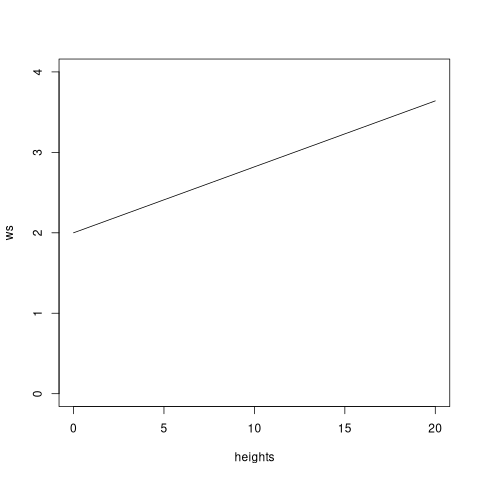

In [12]:
%%R 
f2 <- function(x) {x * 0.082 + 2}
heights <- seq(0,20,5)
ws <- f2(heights)
plot(heights, ws, type = "l", ylim = c(0,4))

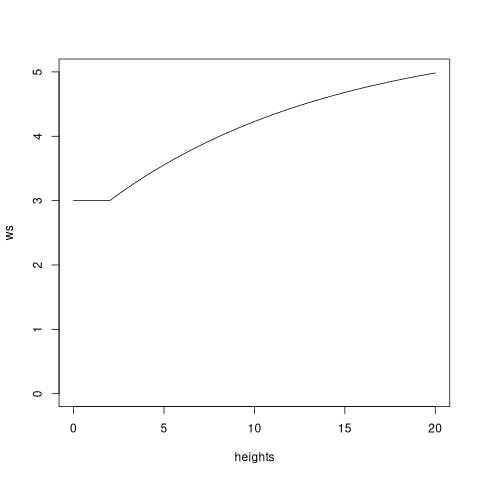

In [14]:
%%R 
f3 <- function(x) {
  y <- 2.6 * (-(exp(-0.08*(x-2)) - 1)) + 3
  y[x < 2] <- 3
  y[x > 20] <- 5
  return(y)
}
heights <- seq(0,20,0.5)
ws <- f3(heights)
plot(heights, ws, type = "l",  ylim = c(0,5))

Use all 3 functions to calcualte the tree tops based on different resolutions 

In [16]:
%%R 
# ALL DEPENDED ON THE ABOVE WINDOW SIZE
#ttops_chm_p2r_05 <- locate_trees(chm_p2r_05, lmf(f))
ttops_chm_p2r_1 <- locate_trees(chm_p2r_1, lmf(f))
#ttops_chm_p2r_2 <- locate_trees(chm_p2r_2, lmf(f))
#ttops_chm_p2r_3 <- locate_trees(chm_p2r_3, lmf(f))

# ALL DEPENDED ON THE ABOVE WINDOW SIZE
#ttops_chm_p2r_05f2 <- locate_trees(chm_p2r_05, lmf(f2))
ttops_chm_p2r_1f2 <- locate_trees(chm_p2r_1, lmf(f2))
#ttops_chm_p2r_2f2 <- locate_trees(chm_p2r_2, lmf(f2))
#ttops_chm_p2r_3f2 <- locate_trees(chm_p2r_3, lmf(f2))
# ALL DEPENDED ON THE ABOVE WINDOW SIZE
#ttops_chm_p2r_05f3 <- locate_trees(chm_p2r_05, lmf(f3))
ttops_chm_p2r_1f3 <- locate_trees(chm_p2r_1, lmf(f3))
#ttops_chm_p2r_2f3 <- locate_trees(chm_p2r_2, lmf(f3))
#ttops_chm_p2r_3f3 <- locate_trees(chm_p2r_3, lmf(f3))

#print(nrow(ttops_chm_p2r_05))
print(nrow(ttops_chm_p2r_1))
#print(nrow(ttops_chm_p2r_2))
#print(nrow(ttops_chm_p2r_3))
#p2r <- nrow(ttops_chm_p2r_05)
#p2r <- nrow(ttops_chm_p2r_1)
#p2r <- nrow(ttops_chm_p2r_2)
#p2r <- nrow(ttops_chm_p2r_3)
#average <- mean(p2r)
#print(paste("The average P2R for Function 1 is", average))
#print(nrow(ttops_chm_p2r_05f2))
print(nrow(ttops_chm_p2r_1f2))
#print(nrow(ttops_chm_p2r_2f2))
#print(nrow(ttops_chm_p2r_3f2))
#p2r2 <- nrow(ttops_chm_p2r_05f2)
#p2r2 <- nrow(ttops_chm_p2r_1f2)
#p2r2 <- nrow(ttops_chm_p2r_2f2)
#p2r2 <- nrow(ttops_chm_p2r_3f2)
#average2 <- mean(p2r2)
#print(paste("The average P2R for Function 2 is", average2))
#print(nrow(ttops_chm_p2r_05f3))
print(nrow(ttops_chm_p2r_1f3))
#print(nrow(ttops_chm_p2r_2f3))
#print(nrow(ttops_chm_p2r_3f3))
#p2r3 <- nrow(ttops_chm_p2r_05f3)
#p2r3 <- nrow(ttops_chm_p2r_1f3)
#p2r3 <- nrow(ttops_chm_p2r_2f3)
#p2r3 <- nrow(ttops_chm_p2r_3f3)
#average3 <- mean(p2r3)
#print(paste("The average P2R for Function 3 is", average3))

[1] 830
[1] 1483
[1] 1637


## next iterate the p2r again to smooth the results 

In [341]:

%%R 
# ALL DEPENDED ON THE ABOVE WINDOW SIZE
ttops_chm_p2r_05_smoothed <- locate_trees(chm_p2r_05, lmf(f))
ttops_chm_p2r_1_smoothed <- locate_trees(chm_p2r_1, lmf(f))
ttops_chm_p2r_2_smoothed <- locate_trees(chm_p2r_2, lmf(f))
ttops_chm_p2r_3_smoothed <- locate_trees(chm_p2r_3, lmf(f))

# ALL DEPENDED ON THE ABOVE WINDOW SIZE
ttops_chm_p2r_05f2_smoothed <- locate_trees(chm_p2r_05, lmf(f2))
ttops_chm_p2r_1f2_smoothed <- locate_trees(chm_p2r_1, lmf(f2))
ttops_chm_p2r_2f2_smoothed <- locate_trees(chm_p2r_2, lmf(f2))
ttops_chm_p2r_3f2_smoothed <- locate_trees(chm_p2r_3, lmf(f2))
# ALL DEPENDED ON THE ABOVE WINDOW SIZE
ttops_chm_p2r_05f3_smoothed <- locate_trees(chm_p2r_05, lmf(f3))
ttops_chm_p2r_1f3_smoothed <- locate_trees(chm_p2r_1, lmf(f3))
ttops_chm_p2r_2f3_smoothed <- locate_trees(chm_p2r_2, lmf(f3))
ttops_chm_p2r_3f3_smoothed <- locate_trees(chm_p2r_3, lmf(f3))

print(nrow(ttops_chm_p2r_05_smoothed))
print(nrow(ttops_chm_p2r_1_smoothed))
print(nrow(ttops_chm_p2r_2_smoothed))
print(nrow(ttops_chm_p2r_3_smoothed))
p2r <- nrow(ttops_chm_p2r_05_smoothed)
p2r <- nrow(ttops_chm_p2r_1_smoothed)
p2r <- nrow(ttops_chm_p2r_2_smoothed)
p2r <- nrow(ttops_chm_p2r_3_smoothed)
average <- mean(p2r)
print(paste("The average P2R_smoothed for Function 1 is", average))
print(nrow(ttops_chm_p2r_05f2_smoothed))
print(nrow(ttops_chm_p2r_1f2_smoothed))
print(nrow(ttops_chm_p2r_2f2_smoothed))
print(nrow(ttops_chm_p2r_3f2_smoothed))
p2r2 <- nrow(ttops_chm_p2r_05f2_smoothed)
p2r2 <- nrow(ttops_chm_p2r_1f2_smoothed)
p2r2 <- nrow(ttops_chm_p2r_2f2_smoothed)
p2r2 <- nrow(ttops_chm_p2r_3f2_smoothed)
average2 <- mean(p2r2)
print(paste("The average P2R_smoothed for Function 2 is", average2))
print(nrow(ttops_chm_p2r_05f3_smoothed))
print(nrow(ttops_chm_p2r_1f3_smoothed))
print(nrow(ttops_chm_p2r_2f3_smoothed))
print(nrow(ttops_chm_p2r_3f3_smoothed))
p2r3 <- nrow(ttops_chm_p2r_05f3_smoothed)
p2r3 <- nrow(ttops_chm_p2r_1f3_smoothed)
p2r3 <- nrow(ttops_chm_p2r_2f3_smoothed)
p2r3 <- nrow(ttops_chm_p2r_3f3_smoothed)
average3 <- mean(p2r3)
print(paste("The average P2R_smoothed for Function 3 is", average3))

[1] 860
[1] 830
[1] 737
[1] 781
[1] "The average P2R_smoothed for Function 1 is 781"
[1] 1476
[1] 1483
[1] 1492
[1] 6215
[1] "The average P2R_smoothed for Function 2 is 6215"
[1] 1656
[1] 1637
[1] 1743
[1] 9100
[1] "The average P2R_smoothed for Function 3 is 9100"


## Next we plot the 4 P2R results

[1] "character"
[1] "tree count"
[1] 860
[1] "character"
[1] "tree count"
[1] 830
[1] "character"
[1] "tree count"
[1] 737
[1] "character"
[1] "tree count"
[1] 781


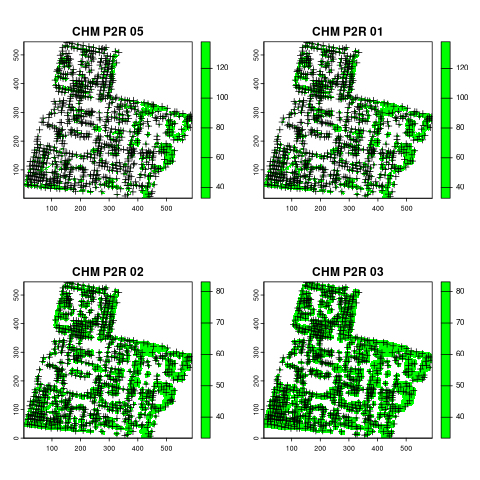

In [342]:
%%R
# Set the layout to have two plots side by side
par(mfrow = c(2, 2))

# Block 1
col <- "green"
print(class(col))  # Check the class of col
plot(chm_p2r_05_smoothed, main = "CHM P2R 05", col = col)
plot(sf::st_geometry(ttops_chm_p2r_05_smoothed), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_p2r_05_smoothed))

# Block 2
col <- "green"
print(class(col))  # Check the class of col
plot(chm_p2r_1_smoothed, main = "CHM P2R 01", col = col)
plot(sf::st_geometry(ttops_chm_p2r_1_smoothed), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_p2r_1_smoothed))

# Block 3
col <- "green"
print(class(col))  # Check the class of col
plot(chm_p2r_2_smoothed, main = "CHM P2R 02", col = col)
plot(sf::st_geometry(ttops_chm_p2r_2_smoothed), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_p2r_2_smoothed))

# Block 3
col <- "green"
print(class(col))  # Check the class of col
plot(chm_p2r_3_smoothed, main = "CHM P2R 03", col = col)
plot(sf::st_geometry(ttops_chm_p2r_3_smoothed), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_p2r_3_smoothed))

# Reset the layout to the default
par(mfrow = c(1, 1))

## Finally, we do the same for the Pitfree algorithm

In [343]:
%%R
# PITFREE
ttops_chm_pitfree_05_1 <- locate_trees(chm_pitfree_05_1, lmf(f))
ttops_chm_pitfree_05_2 <- locate_trees(chm_pitfree_05_2, lmf(f))
ttops_chm_pitfree_05_3 <- locate_trees(chm_pitfree_05_3, lmf(f))
ttops_chm_pitfree_05_3s <- locate_trees(chm_pitfree_05_3s, lmf(f))

ttops_chm_pitfree_05_1f2 <- locate_trees(chm_pitfree_05_1, lmf(f2))
ttops_chm_pitfree_05_2f2 <- locate_trees(chm_pitfree_05_2, lmf(f2))
ttops_chm_pitfree_05_3f2 <- locate_trees(chm_pitfree_05_3, lmf(f2))
ttops_chm_pitfree_05_3sf2 <- locate_trees(chm_pitfree_05_3s, lmf(f2))

ttops_chm_pitfree_05_1f3 <- locate_trees(chm_pitfree_05_1, lmf(f3))
ttops_chm_pitfree_05_2f3 <- locate_trees(chm_pitfree_05_2, lmf(f3))
ttops_chm_pitfree_05_3f3 <- locate_trees(chm_pitfree_05_3, lmf(f3))
ttops_chm_pitfree_05_3sf3 <- locate_trees(chm_pitfree_05_3s, lmf(f3))
print("pitfree")
print(nrow(ttops_chm_pitfree_05_1))
print(nrow(ttops_chm_pitfree_05_2))
print(nrow(ttops_chm_pitfree_05_3))
print(nrow(ttops_chm_pitfree_05_3s))
pf <- nrow(ttops_chm_pitfree_05_1)
pf <- nrow(ttops_chm_pitfree_05_2)
pf <- nrow(ttops_chm_pitfree_05_3)
pf <- nrow(ttops_chm_pitfree_05_3s)
averagepf <- mean(pf)
print(paste("The average P2R_smoothed for Function 1 is", averagepf))

print(nrow(ttops_chm_pitfree_05_1f2))
print(nrow(ttops_chm_pitfree_05_2f2))
print(nrow(ttops_chm_pitfree_05_3f2))
print(nrow(ttops_chm_pitfree_05_3sf2))
pf2 <- nrow(ttops_chm_pitfree_05_1f2)
pf2 <- nrow(ttops_chm_pitfree_05_2f2)
pf2 <- nrow(ttops_chm_pitfree_05_3f2)
pf2 <- nrow(ttops_chm_pitfree_05_3sf2)
averagepf2 <- mean(pf2)
print(paste("The average pitfree for Function 2 is", averagepf2))

print(nrow(ttops_chm_pitfree_05_1f3))
print(nrow(ttops_chm_pitfree_05_2f3))
print(nrow(ttops_chm_pitfree_05_3f3))
print(nrow(ttops_chm_pitfree_05_3sf3))
pf3 <- nrow(ttops_chm_pitfree_05_1f3)
pf3 <- nrow(ttops_chm_pitfree_05_2f3)
pf3 <- nrow(ttops_chm_pitfree_05_3f3)
pf3 <- nrow(ttops_chm_pitfree_05_3sf3)
averagepf3 <- mean(pf3)
print(paste("The average Pitfree for Function 3 is", averagepf3))


[1] "pitfree"
[1] 662
[1] 582
[1] 563
[1] 565
[1] "The average P2R_smoothed for Function 1 is 565"
[1] 1252
[1] 1523
[1] 18697
[1] 18772
[1] "The average pitfree for Function 2 is 18772"
[1] 1408
[1] 1947
[1] 24171
[1] 24170
[1] "The average Pitfree for Function 3 is 24170"


[1] "character"
[1] "tree count"
[1] 662
[1] "character"
[1] "tree count"
[1] 582
[1] "character"
[1] "tree count"
[1] 563
[1] "character"
[1] "tree count"
[1] 565


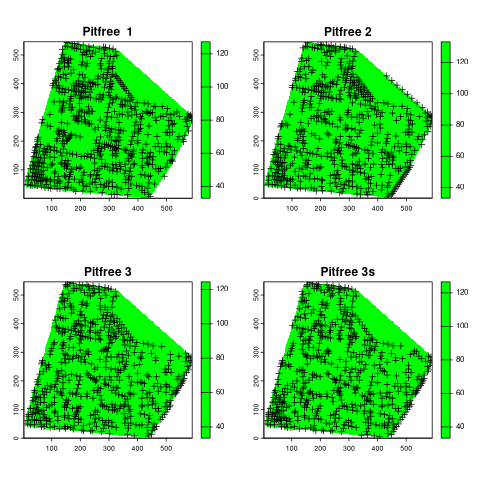

In [344]:
%%R
# Set the layout to have two plots side by side
par(mfrow = c(2, 2))

# Block 1
col <- "green"
print(class(col))  # Check the class of col
plot(chm_pitfree_05_1, main = "Pitfree  1", col = col)
plot(sf::st_geometry(ttops_chm_pitfree_05_1), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_pitfree_05_1))

# Block 2
col <- "green"
print(class(col))  # Check the class of col
plot(chm_pitfree_05_2, main = "Pitfree 2", col = col)
plot(sf::st_geometry(ttops_chm_pitfree_05_2), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_pitfree_05_2))

# Block 3
col <- "green"
print(class(col))  # Check the class of col
plot(chm_pitfree_05_3, main = "Pitfree 3", col = col)
plot(sf::st_geometry(ttops_chm_pitfree_05_3), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_pitfree_05_3))

# Block 3
col <- "green"
print(class(col))  # Check the class of col
plot(chm_pitfree_05_3s, main = "Pitfree 3s", col = col)
plot(sf::st_geometry(ttops_chm_pitfree_05_3s), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_pitfree_05_3s))

# Reset the layout to the default
par(mfrow = c(1, 1))

# NEXT STEP - TREE CROWNS
earlier calculated ttops and foresttools crowns are different aspects of tree analysis in the ForestTools package. The ttops are the treetops detected from a CHM, and the foresttools crowns are the tree crowns outlined from these treetops.

since crown function needs spatRaster we have to reload the las file 

uses the same window size function as above!

for foresttools crown support the vwf algorithm has to be used

[1] 545


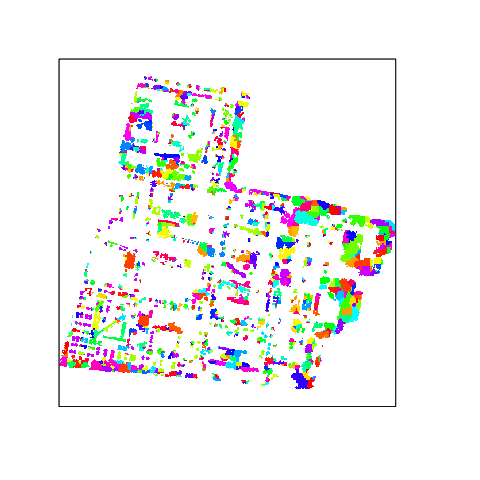

In [345]:
%%R 
chm <- rasterize_canopy(las, 1, p2r(0.6), pkg = "raster")
#f <- function(x) {x * 0.02 + 0.3}

ttops <- vwf(CHM = chm, winFun = f, minHeight = 2)

plot(chm, xlab = "", ylab = "", xaxt = 'n', yaxt = 'n')
plot(ttops, col = "green", pch = 20, cex = 0.5, add = TRUE)

# Create crown map
crowns <- mcws(treetops = ttops, CHM = chm,  minHeight = 3, verbose = FALSE)

# Plot crowns
plot(crowns, col = sample(rainbow(50), length(unique(crowns[])), replace = TRUE), legend = FALSE, xlab = "", ylab = "", xaxt='n', yaxt = 'n')
print(nrow(crowns))

In [346]:
%%R
crowns_poly <- mcws(treetops = ttops, CHM = chm, minHeight = 3, verbose = FALSE, format="polygons")
summary <- sp_summarise(crowns_poly, variables = c("crownArea", "height"))
print(summary)
# Calculate total crown area
total_crown_area <- sum(crowns_poly$crownArea)

# Print total crown area
print(paste("Total Crown Area :", total_crown_area))

                      Value
TreeCount       1425.000000
crownAreaMean     41.072281
crownAreaMedian   15.000000
crownAreaSD       70.090689
crownAreaMin       1.000000
crownAreaMax     911.000000
heightMean        49.223158
heightMedian      46.010000
heightSD           9.397892
heightMin         34.790000
heightMax        137.890000
[1] "Total Crown Area : 58528"


In [347]:
%%R 
# Read the LAS file
las2 <- readLAS("/home/nibe/PROJECTS/golm_tree_analysis/data/Golm_May06_2018_Milan_UTM33N_WGS84_6digit_cl.las")
# Specify the resolution of the raster data
resolution <- 1
# Create a grid using the grid_metrics function
# Here we use the length function as our metric, which will return 1 for all grid cells that contain at least one point.
metrics <- grid_metrics(las2, ~length(X), resolution)

# Calculate the total area covered by the .las file
# Total area is computed by summing up non-NA grid cells and multiplying by the cell's area
total_area <- sum(!is.na(values(metrics))) * resolution * resolution
print(paste0("Total Area :", total_area))

[1] "Total Area :192458"


This means that to find the total area covered by trees we have to do the following : 

Results is in the output!

In [ ]:
%%R
crown_values <- getValues(crowns)
unique_crowns <- unique(crown_values)

# compare total Crown Area with total area
print(paste0("Proportion of area covered by tree crowns : ", (total_crown_area/total_area)*100, "__%"))